In [2]:
import io
import os
import re
import time
import json
import chromadb
import pdfplumber

from chromadb.config import Settings
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dataclasses import dataclass, asdict
from typing import Dict, Any, List, Optional, Callable
from langgraph.prebuilt import create_react_agent
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

os.environ["ANONYMIZED_TELEMETRY"] = "False"
os.environ["CHROMA_TELEMETRY_DISABLED"] = "True"

In [3]:
from dataclasses import dataclass, asdict
from enum import Enum
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END
from langgraph.graph.state import CompiledStateGraph
from typing_extensions import TypedDict

In [4]:
"""
Supervisor Agent + Agents (Document Ingestion, Compliance, Data Validation)

- Fully self-contained Python module (example).
- Supervisor orchestrates: Ingestion -> Compliance -> Validation -> Final JSON report
- Extensible: register new agents and include them in workflow order.

Notes:
- This file assumes `langchain_openai`, `langgraph`, `langchain_core`, `chromadb`, and `pdfplumber` are available in your environment.
- Update the `PERSIST_DIR` and collection settings to your environment before running compliance queries.
"""

import os
import re
import time
import json
import pdfplumber
from dataclasses import dataclass, asdict
from typing import Any, Dict, List, Optional

# LLM / Agent libs (your environment)
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# Optional (if you use Chroma for compliance matching)
try:
    import chromadb
    from chromadb.config import Settings
    from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
    CHROMA_AVAILABLE = True
except Exception:
    CHROMA_AVAILABLE = False

In [5]:
# -----------------------------
# Tool: PDF extractor (ingestion primitive)
# -----------------------------
@tool
def extract_pdf_metadata_and_text(file_path: str) -> Dict[str, Any]:
    """Extract metadata and text blocks from a PDF provided as a local file path.

    Returns dict: {"metadata": {...}, "blocks": [{"page": int, "block": int, "text": str}, ...]}
    """
    if not file_path:
        raise ValueError("file_path must be provided.")

    block_texts: List[Dict[str, Any]] = []
    pdf_metadata: Dict[str, Any] = {}

    try:
        with pdfplumber.open(file_path) as pdf:
            pdf_metadata = pdf.metadata or {}

            for page_number, page in enumerate(pdf.pages, start=1):
                text = page.extract_text() or ""
                # simple split into blocks by double newline (tweak for your documents)
                blocks = text.split("\n\n") if text else []

                for block_number, block in enumerate(blocks, start=1):
                    if block.strip():
                        block_texts.append({
                            "page": page_number,
                            "block": block_number,
                            "text": block.strip()
                        })

    except Exception as e:
        return {"error": f"Failed to process PDF: {str(e)}"}

    return {"metadata": pdf_metadata, "blocks": block_texts}


# -----------------------------
# Ingestion agent (wrapper around extractor)
# -----------------------------
@dataclass
class IngestionReport:
    agent_name: str
    status: str
    file_path: str
    total_blocks: int
    pages: int
    warnings: List[str]
    params_used: Dict[str, Any]
    timings_ms: Dict[str, int]
    error: Optional[str] = None


class DocumentIngestionAgent:
    """Programmatic ingestion agent with retry strategies and reporting."""

    def __init__(self, max_size_mb: int = 100, min_blocks_ok: int = 1, ocr_enabled: bool = False):
        self.agent_name = "Document Ingestion Agent"
        self.max_size_bytes = max_size_mb * 1024 * 1024
        self.min_blocks_ok = min_blocks_ok
        self.ocr_enabled = ocr_enabled

    def prechecks(self, filepath: str) -> List[str]:
        warnings: List[str] = []
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"File not found: {filepath}")
        if not os.path.isfile(filepath):
            raise ValueError(f"Not a file: {filepath}")
        size = os.path.getsize(filepath)
        if size > self.max_size_bytes:
            warnings.append(f"Large file: {size / 1e6:.1f} MB")
        return warnings

    def low_text_density(self, result: Dict[str, Any]) -> bool:
        blocks = result.get("blocks", [])
        total_chars = sum(len(b.get("text", "")) for b in blocks)
        return (len(blocks) < 3) or (total_chars < 200)

    def invoke_extractor(self, file_path: str, strategy: str) -> Dict[str, Any]:
        # Could branch on strategy for different inference/ocr pipelines.
        # Call the tool directly (it's safe to do so in Python runtime).
        return extract_pdf_metadata_and_text.invoke({"file_path": file_path})

    def ingest(self, file_path: str) -> Dict[str, Any]:
        t0 = time.time()
        warnings: List[str] = []
        params_used = {"strategy": "fast_text", "ocr_enabled": self.ocr_enabled}
        timings_ms: Dict[str, int] = {}

        try:
            warnings += self.prechecks(file_path)
            t1 = time.time(); timings_ms["prechecks"] = int((t1 - t0) * 1000)

            # First attempt: fast path
            r1 = self.invoke_extractor(file_path, strategy="fast_text")
            timings_ms["extract_fast"] = int((time.time() - t1) * 1000)

            if "error" in r1:
                warnings.append(f"Extractor error (fast): {r1['error']}")

            needs_retry = ("error" in r1) or (len(r1.get("blocks", [])) < self.min_blocks_ok)

            if needs_retry and self.ocr_enabled and self.low_text_density(r1 if "error" not in r1 else {"blocks": []}):
                params_used["strategy"] = "ocr_pipeline"
                t2 = time.time()
                # r2 = run_ocr_pipeline(file_path)  # implement real OCR pipeline here
                r2 = r1
                timings_ms["extract_ocr"] = int((time.time() - t2) * 1000)
                base = r2
            elif needs_retry:
                params_used["strategy"] = "layout_text"
                t2 = time.time()
                r2 = self.invoke_extractor(file_path, strategy="layout_text")
                timings_ms["extract_layout"] = int((time.time() - t2) * 1000)
                base = r2
            else:
                base = r1

            blocks = base.get("blocks", []) if "error" not in base else []

            pages = base.get("metadata", {}).get("Pages") or base.get("metadata", {}).get("page_count") or None

            result = {
                **base,
                "status": "success" if "error" not in base and len(blocks) >= self.min_blocks_ok else "error",
                "file_path": file_path,
                "total_blocks": len(blocks),
                "warnings": warnings,
            }

            report = IngestionReport(
                agent_name=self.agent_name,
                status=result["status"],
                file_path=file_path,
                total_blocks=len(blocks),
                pages=pages if isinstance(pages, int) else (len(set(b["page"] for b in blocks)) if blocks else 0),
                warnings=warnings,
                params_used=params_used,
                timings_ms=timings_ms,
                error=base.get("error"),
            )

            result["report"] = asdict(report)
            return result

        except Exception as e:
            report = IngestionReport(
                agent_name=self.agent_name,
                status="error",
                file_path=file_path,
                total_blocks=0,
                pages=0,
                warnings=warnings,
                params_used=params_used,
                timings_ms=timings_ms,
                error=str(e),
            )
            return {"status": "error", "error": str(e), "file_path": file_path, "report": asdict(report)}


# -----------------------------
# Compliance tool / agent
# -----------------------------
PERSIST_DIR = r"D:\Docketry\IPFS_deploy\OLD\PFAEBACH\Multi AGENTS\build_kb"
COLLECTION_NAME = "Clinical_guidelines"
EMBED_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

chroma_client = None
collection = None
if CHROMA_AVAILABLE:
    chroma_client = chromadb.PersistentClient(
        path=PERSIST_DIR,
        settings=Settings(anonymized_telemetry=False)
    )
    embed_fn = SentenceTransformerEmbeddingFunction(model_name=EMBED_MODEL)
    try:
        collection = chroma_client.get_collection(COLLECTION_NAME, embedding_function=embed_fn)
    except Exception:
        # create_collection or handle missing collection as needed
        collection = chroma_client.get_or_create_collection(COLLECTION_NAME, embedding_function=embed_fn)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given


In [6]:
@tool
def check_compliance(ingested_doc: Dict[str, Any]) -> Dict[str, Any]:
    """
    Review the ingested document blocks for compliance with regulatory guidelines.

    Args:
        ingested_doc: Dictionary output from Document Ingestion Agent
                      (must include "blocks" with text)

    Returns:
        Compliance report with flagged issues
    """
    if not ingested_doc or "blocks" not in ingested_doc:
        raise ValueError("Invalid input. Expected dict with 'blocks' from ingestion agent.")

    compliance_report: List[Dict[str, Any]] = []

    for block in ingested_doc["blocks"]:
        findings: List[Dict[str, Any]] = []
        if collection is not None:
            res = collection.query(
                query_texts=[block["text"]],
                n_results=3,
                include=["documents", "metadatas", "distances"],
            )
            # res format: dict with keys: ids, documents, metadatas, distances
            for i in range(len(res["ids"][0])):
                dist = res["distances"][0][i]
                # convert distance -> similarity heuristic
                if dist > 0.7:
                    continue
                findings.append({
                    "guideline_excerpt": res["documents"][0][i],
                    "metadata": res["metadatas"][0][i],
                    "similarity_score": float(1 - dist)
                })
        else:
            # If no vector DB available, provide a placeholder/no-op behavior
            findings = []

        compliance_report.append({
            "page": block["page"],
            "block": block["block"],
            "text": block["text"],
            "is_compliant": bool(findings),
            "findings": findings
        })

    return {
        "status": "review_complete",
        "total_blocks": len(ingested_doc["blocks"]),
        "compliance_report": compliance_report
    }


def create_compliance_agent(llm: Optional[ChatOpenAI] = None):
    llm = llm or ChatOpenAI(model="gpt-4o-mini", temperature=0)
    agent = create_react_agent(
        model=llm,
        tools=[check_compliance],
        state_modifier=(
            "You are a Compliance Agent.\n"
            "When given ingested document data, you MUST use the check_compliance tool.\n"
            "Return only the structured compliance report."
        ),
        name="compliance_agent",
    )
    return agent

In [ ]:
# -----------------------------
# Validation tool / agent
# -----------------------------
@tool
def validate_patient_data(doc: Dict[str, Any]) -> Dict[str, Any]:
    """
    Cross-reference demographics, inclusion/exclusion criteria, and consent form data.

    Args:
        doc: Dictionary output from Document Ingestion Agent (with 'blocks')

    Returns:
        Validation report highlighting matched/mismatched conditions
    """
    if "blocks" not in doc:
        raise ValueError("Invalid input: expected 'blocks' in ingested document.")

    text_content = " ".join([b["text"] for b in doc["blocks"]])

    report = {
        "status": "validation_complete",
        "checks": []
    }

    demographics = {}
    age_match = re.search(r"Age[: ](\d+)", text_content)
    if age_match:
        demographics["age"] = int(age_match.group(1))

    gender_match = re.search(r"Gender[: ](Male|Female|Other)", text_content, re.IGNORECASE)
    if gender_match:
        demographics["gender"] = gender_match.group(1).capitalize()

    protocol_inclusion = {"min_age": 18, "max_age": 65, "allowed_genders": ["Male", "Female"]}
    protocol_exclusion = {"conditions": ["pregnant", "history of cancer"]}

    if "age" in demographics:
        valid_age = protocol_inclusion["min_age"] <= demographics["age"] <= protocol_inclusion["max_age"]
        report["checks"].append({
            "field": "Age",
            "value": demographics["age"],
            "rule": f"{protocol_inclusion['min_age']}–{protocol_inclusion['max_age']}",
            "is_valid": valid_age
        })

    if "gender" in demographics:
        valid_gender = demographics["gender"] in protocol_inclusion["allowed_genders"]
        report["checks"].append({
            "field": "Gender",
            "value": demographics["gender"],
            "rule": f"Allowed: {protocol_inclusion['allowed_genders']}",
            "is_valid": valid_gender
        })

    for condition in protocol_exclusion["conditions"]:
        found = condition.lower() in text_content.lower()
        report["checks"].append({
            "field": "Exclusion",
            "condition": condition,
            "found_in_doc": found,
            "is_valid": not found
        })

    return report


def create_data_validation_agent(llm: Optional[ChatOpenAI] = None):
    llm = llm or ChatOpenAI(model="gpt-4o-mini", temperature=0)
    agent = create_react_agent(
        model=llm,
        tools=[validate_patient_data],
        state_modifier=(
            "You are a Data Validation Agent.\n"
            "Your task is to cross-check demographics, inclusion/exclusion criteria, and consent form details.\n"
            "Always use the `validate_patient_data` tool and return only the structured validation report."
        ),
        name="validation_agent",
    )
    return agent


# -----------------------------
# Helper: sanitize objects for JSON serialization
# -----------------------------

# def sanitize_for_json(obj):
#     """Recursively convert non-JSON-serializable objects into JSON-friendly primitives.

#     - Converts dataclasses via dataclasses.asdict
#     - Converts LangChain BaseMessage (SystemMessage/HumanMessage/AIMessage) to dict with type/content
#     - Recurses through lists/tuples/sets/dicts
#     - Falls back to str(obj) when necessary
#     """
#     import dataclasses
#     try:
#         # dataclass -> dict
#         if dataclasses.is_dataclass(obj):
#             return {k: sanitize_for_json(v) for k, v in dataclasses.asdict(obj).items()}
#     except Exception:
#         pass

#     # LangChain message objects
#     try:
#         from langchain_core.messages import BaseMessage
#         if isinstance(obj, BaseMessage):
#             return {"type": type(obj).__name__, "content": getattr(obj, "content", str(obj))}
#     except Exception:
#         # langchain may not be available or named differently in some environments
#         pass

#     # dict
#     if isinstance(obj, dict):
#         return {sanitize_for_json(k): sanitize_for_json(v) for k, v in obj.items()}

#     # list/tuple/set
#     if isinstance(obj, (list, tuple, set)):
#         return [sanitize_for_json(i) for i in obj]

#     # primitives
#     try:
#         import json as _json
#         _json.dumps(obj)
#         return obj
#     except Exception:
#         return str(obj)


# Jane as a supervisor agent

Pipeline stage (automatic) → Ingestion → Compliance → Validation → JSON Summary.

This runs once on the PDF.

Produces the structured JSON report.

Interactive stage (on-demand) → After pipeline is done, if the user asks a question, Supervisor should route only to Jane.

Jane uses the already-processed data (summary + blocks) for Q&A.

# Supervisor for Pipeline Stage

In [10]:
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph_supervisor import create_supervisor

In [11]:
compliance_agent = create_compliance_agent()
validation_agent = create_data_validation_agent()

In [12]:
supervisor_pipeline = create_supervisor(
    model=ChatOpenAI(model="gpt-4o-mini", temperature=0),
    agents=[compliance_agent, validation_agent],  # Only pipeline agents
    state_modifier=(
        "You are a Supervisor Agent responsible for orchestrating clinical trial document review.\n"
        "Workflow:\n"
        "1. First, call the DocumentIngestionAgent to ingest the PDF.\n"
        "2. Next, send the ingested output to the Compliance Agent.\n"
        "3. Then, send both ingestion + compliance outputs to the Data Validation Agent.\n"
        "4. Finally, summarize everything into a structured JSON report.\n\n"
        "Rules:\n"
        "- Always call these steps in sequence.\n"
        "- Never skip or merge steps.\n"
        "- Return only the JSON summary report as final output."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile(name="supervisor_pipeline")

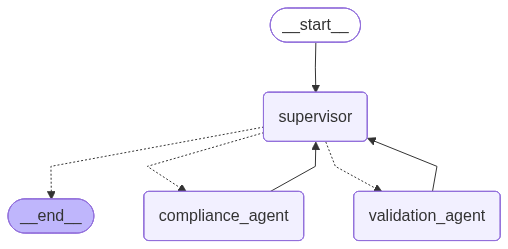

In [13]:
from IPython.display import display, Image
display(Image(supervisor_pipeline.get_graph().draw_mermaid_png()))

# ---------- PIPELINE STAGE ----------

In [14]:
# ✅ Initialize your agents
document_ingestion = DocumentIngestionAgent(
    max_size_mb=200, min_blocks_ok=1, ocr_enabled=False
)

In [91]:
# pdf_path = "D:\\Docketry\\IPFS_deploy\\OLD\\PFAEBACH\\Multi AGENTS\\ClinicalGuidance_Pdf\\UCM609513.pdf"
pdf_path = r"D:\Docketry\IPFS_deploy\OLD\PFAEBACH\Multi AGENTS\clinical_study_summary.pdf"

# ---------- PIPELINE STAGE ----------
ingested = document_ingestion.ingest(pdf_path)

for chunk in supervisor_pipeline.stream({
    "messages": [{"role": "user", "content": json.dumps(ingested)}]
}):
    pass  # run through pipeline

final_pipeline_result = chunk["supervisor"]["messages"][-1].content
print("PIPELINE JSON SUMMARY:\n", final_pipeline_result)

PIPELINE JSON SUMMARY:
 The document is a clinical study summary titled "The Effects of Acupuncture in Overcoming Inflammatory Response to COVID-19 Mild-moderate Symptoms." It outlines a completed interventional study that investigated the effects of acupuncture combined with standard care on hospitalized COVID-19 patients with mild to moderate symptoms. 

### Key Details:

- **Study Status**: Completed
- **Study Type**: Interventional
- **Start Date**: September 1, 2020
- **Completion Date**: November 20, 2020

### Summary:
The study addresses the COVID-19 pandemic, highlighting the rapid spread of the virus and the high death rate in Indonesia. It notes that no effective therapy or vaccine was available at the time of the study, and current management focused on supportive care. The study suggests that acupuncture may help boost the immune system and provide anti-inflammatory effects, particularly in patients with mild to moderate symptoms.

### Primary Outcomes:
1. **Lymphocyte Coun

In [92]:
pipeline_summary = final_pipeline_result
print("PIPELINE JSON SUMMARY:\n", pipeline_summary)

PIPELINE JSON SUMMARY:
 The document is a clinical study summary titled "The Effects of Acupuncture in Overcoming Inflammatory Response to COVID-19 Mild-moderate Symptoms." It outlines a completed interventional study that investigated the effects of acupuncture combined with standard care on hospitalized COVID-19 patients with mild to moderate symptoms. 

### Key Details:

- **Study Status**: Completed
- **Study Type**: Interventional
- **Start Date**: September 1, 2020
- **Completion Date**: November 20, 2020

### Summary:
The study addresses the COVID-19 pandemic, highlighting the rapid spread of the virus and the high death rate in Indonesia. It notes that no effective therapy or vaccine was available at the time of the study, and current management focused on supportive care. The study suggests that acupuncture may help boost the immune system and provide anti-inflammatory effects, particularly in patients with mild to moderate symptoms.

### Primary Outcomes:
1. **Lymphocyte Coun

# ---------- INTERACTIVE QA STAGE ----------

In [29]:
# TOOL: QA over processed document
@tool
def answer_question_on_doc(processed_doc: Dict[str, Any], question: str) -> Dict[str, Any]:
    """
    Answer natural language questions about the processed document.
    Args:
        processed_doc: Dictionary with ingested + compliance + validation results
        question: User query
    Returns:
        Dict with structured answer
    """
    if not processed_doc or "blocks" not in processed_doc:
        raise ValueError("Invalid processed document.")

    all_text = " ".join([b["text"] for b in processed_doc["blocks"]])
    return {
        "status": "qa_complete",
        "question": question,
        "answer_context": all_text[:2000]  # keep context short for efficiency
    }


def create_jane_agent():
    """Interactive QA agent that answers questions on processed document."""
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    return create_react_agent(
        model=llm,
        tools=[answer_question_on_doc],
        state_modifier=(
            "You are Jane, a helpful QA Agent.\n"
            "When a user asks a question about the processed document, "
            "you MUST use the answer_question_on_doc tool.\n"
            "Return answers in structured JSON format."
        ),
        name="jane_agent",
    )

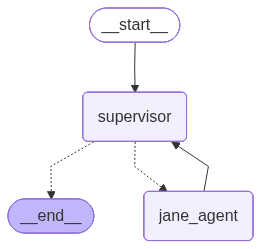

In [30]:
jane_agent = create_jane_agent()

supervisor_qa = create_supervisor(
    model=ChatOpenAI(model="gpt-4o-mini", temperature=0),
    agents=[jane_agent],  # Only Jane
    state_modifier=(
        "You are a Supervisor for post-processing Q&A.\n"
        "Workflow:\n"
        "- If the user asks a question about the processed document, "
        "send it to Jane (the QA Agent).\n"
        "- Return JSON answers only.\n"
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile(name="supervisor_qa")

from IPython.display import display, Image
display(Image(supervisor_qa.get_graph().draw_mermaid_png()))

In [31]:
config = {"recursion_limit": 10}

In [93]:
# question = "What inclusion criteria violations are present in this document?"
question = "What was the primary objective of this clinical study on acupuncture?"

In [94]:
last_chunk = None
for chunk in supervisor_qa.stream({
    "messages": [
        {"role": "system", "content": f"Here is the processed document JSON:\n{pipeline_summary}"},
        {"role": "user", "content": question}
    ]
}, config=config):
    last_chunk = chunk
    print(f"Chunk: {list(chunk.keys())}")  # Debug: see what's happening

# if not last_chunk:
#     raise RuntimeError("Stream produced no output")

Chunk: ['supervisor']


In [95]:
last_chunk

{'supervisor': {'messages': [SystemMessage(content='Here is the processed document JSON:\nThe document is a clinical study summary titled "The Effects of Acupuncture in Overcoming Inflammatory Response to COVID-19 Mild-moderate Symptoms." It outlines a completed interventional study that investigated the effects of acupuncture combined with standard care on hospitalized COVID-19 patients with mild to moderate symptoms. \n\n### Key Details:\n\n- **Study Status**: Completed\n- **Study Type**: Interventional\n- **Start Date**: September 1, 2020\n- **Completion Date**: November 20, 2020\n\n### Summary:\nThe study addresses the COVID-19 pandemic, highlighting the rapid spread of the virus and the high death rate in Indonesia. It notes that no effective therapy or vaccine was available at the time of the study, and current management focused on supportive care. The study suggests that acupuncture may help boost the immune system and provide anti-inflammatory effects, particularly in patients

In [96]:
message = last_chunk["supervisor"]["messages"][-1]
jane_answer = message.content
print("JANE's ANSWER:\n", jane_answer)

JANE's ANSWER:
 The primary objective of the clinical study was to investigate the effects of acupuncture combined with standard care on hospitalized COVID-19 patients with mild to moderate symptoms, specifically focusing on its potential to boost the immune system and provide anti-inflammatory effects. The study aimed to measure changes in various health indicators, such as lymphocyte count, erythrocyte sedimentation rate, ferritin level, C-reactive protein level, and clinical changes like the duration of cough and fever during hospitalization.


# Store pipeline result in Jane’s tool

In [ ]:
# from qdrant_client import QdrantClient
# from mem0 import Memory

# # client = QdrantClient(path=r"C:\Users\ganga.babu\.mem0\qdrant_local")  # on-disk local mode
# client = QdrantClient(path=r"D:\Docketry\IPFS_deploy\OLD\PFAEBACH\Multi AGENTS\.mem0\qdrant_local")  # on-disk local mode

# config = {
#   "vector_store": {
#     "provider": "qdrant",
#     "config": {
#       "collection_name": "mem0",
#       "client": client,
#       "embedding_model_dims": 1536
#     }
#   }
# }
# memory = Memory.from_config(config)

# # ... use memory ...

# client.close()  # important on Windows to release .lock before re-init

✅ — wrapping Jane’s supervisor agent so every answer is also stored into mem0 will keep your workflow automatic.

In [42]:
from mem0 import Memory
import os, json
from datetime import datetime
from qdrant_client import QdrantClient

client = QdrantClient(path=r"D:\Docketry\IPFS_deploy\OLD\PFAEBACH\Multi AGENTS\.mem0\qdrant_local")  # on-disk local mode

config = {
  "vector_store": {
    "provider": "qdrant",
    "config": {
      "collection_name": "mem0",
      "client": client,
      "on_disk": True,
      "embedding_model_dims": 1536
    }
  }
}
memory = Memory.from_config(config)

In [ ]:
# When done:
# client.close()

In [73]:
# --- Helper for building dynamic memory entries ---
def make_memory_entry(user_id, source, title, pipeline_summary, final_pipeline_result, question, assistant_response):
    return {
        "user_id": user_id,
        "source": source,
        "title": title,
        "pipeline_summary": pipeline_summary,
        "final_pipeline_result": final_pipeline_result,
        "question": question,
        "assistant_response": assistant_response,
        "created_at": datetime.utcnow().isoformat() + "Z",
    }

def save_memory(memory, entry):
    """Persist memory entry using supported method (add)."""
    try:
        memory.add(
            messages=[
                {"role": "user", "content": entry["question"]},
                {"role": "assistant", "content": entry["final_pipeline_result"]}
            ],
            user_id=entry["user_id"],
            metadata={
                "source": entry["source"],
                "title": entry["title"],
                "pipeline_summary": entry["pipeline_summary"],
                "created_at": entry["created_at"],
            },
        infer=False  # force persistence
        )
        return "✅ Memory saved using add([question, answer], user_id, metadata)"
    except Exception as e:
        return f"⚠️ Memory save failed with add(): {e}"



def run_with_memory(supervisor, messages, ingested, user_id="Jane_Memory"):
    # --- Extract source & title dynamically from PDF metadata ---
    metadata = ingested.get("metadata", {})
    source = metadata.get("Author") or metadata.get("Company") or "Unknown Source"
    title = metadata.get("Title") or metadata.get("Keywords") or "Untitled Document"

    # Run the supervisor agent
    result = supervisor.stream({"messages": messages})
    collected_chunks = []
    for chunk in result:
        collected_chunks.append(chunk)

    # Extract final output (Jane's last answer)
    final_output = collected_chunks[-1]["supervisor"]["messages"][-1].content

    # Build memory entry
    question = messages[-1]["content"] if messages else ""
    entry = make_memory_entry(
        user_id=user_id,
        source=source,
        title=title,
        pipeline_summary=json.dumps(messages, indent=2),  # saves your system+user input
        final_pipeline_result=final_output,
        question=question,
        assistant_response={"response": final_output},
    )

    # Persist to mem0
    result_msg = save_memory(memory, entry)
    print(result_msg)
    print(f"✅ Memory saved for {user_id}: {title}")

    return final_output

In [ ]:
# # When done:
# client.close()

In [39]:
ingested.get('metadata')

{'Author': 'FDA/CDER/mccrayk',
 'Company': 'FDA.CDER',
 'CreationDate': "D:20190227145406-05'00'",
 'Creator': 'Acrobat PDFMaker 11 for Word',
 'Keywords': 'Considerations for the Inclusion of Adolescent Patients in Adult Oncology Clinical Trials\r\nGuidance for Industry',
 'ModDate': "D:20190311134654-04'00'",
 'Producer': 'Adobe PDF Library 11.0',
 'SourceModified': 'D:20190227195348',
 'Subject': 'Guidance for Industry',
 'Title': 'Considerations for the Inclusion of Adolescent Patients in Adult Oncology Clinical Trials, Guidance for Industry',
 '_NewReviewCycle': ''}

In [97]:
# question = "What inclusion criteria violations are present in this document?"
question = "What was the study status and completion date?"

messages = [
    {"role": "system", "content": f"Here is the processed document JSON:\n{pipeline_summary}"},
    {"role": "user", "content": question}
]

answer = run_with_memory(
    supervisor_qa,
    messages,
    ingested=ingested,  # <- passes metadata
    user_id="Jane_Memory"
)

print("Jane’s final answer:", answer)

✅ Memory saved for Jane_Memory: (anonymous)
Jane’s final answer: The study status was "Completed," and the completion date was November 20, 2020.


In [60]:
# help(memory.add)

In [61]:
# print(dir(memory))

## Memory Retrieval / QA on past answers

In [98]:
# results = memory.search("dose selection adolescents", user_id="Jane_Memory")
# results

In [99]:
all_memories = memory.get_all(user_id="Jane_Memory")
all_memories

{'results': [{'id': '73a80dc6-b10b-4fd8-bd41-6d153a33f0ff',
   'memory': 'What inclusion criteria violations are present in this document?',
   'hash': '629fe470a1e2dcaf8a42b3c2074fa5e7',
   'metadata': {'source': 'FDA/CDER/mccrayk',
    'title': 'Considerations for the Inclusion of Adolescent Patients in Adult Oncology Clinical Trials, Guidance for Industry',
    'pipeline_summary': '[\n  {\n    "role": "system",\n    "content": "The document titled \\"Considerations for the Inclusion of Adolescent Patients in Adult Oncology Clinical Trials, Guidance for Industry\\" was published by the U.S. Department of Health and Human Services, specifically the Food and Drug Administration (FDA), in March 2019. It provides guidance for the pharmaceutical industry, clinical investigators, and institutional review boards regarding the inclusion of adolescent patients (ages 12 to 17) in adult oncology clinical trials.\\n\\n### Key Sections of the Document:\\n\\n1. **Introduction**: \\n   - The guidan

In [ ]:
# memory.delete_all(user_id="Jane_Memory")
# print("✅ Cleared all memories for Jane_Memory")

✅ Cleared all memories for Jane_Memory


🔍 Retrieving (Jane’s chain of thought)

In [ ]:
# def recall_memories(memory, query, user_id="Jane_Memory", top_k=5):
#     results = memory.search(query, user_id=user_id)
#     memories = [r["memory"] for r in results.get("results", [])]
#     return memories[:top_k]

# # Example query
# past = recall_memories(memory, "dose selection", user_id="Jane_Memory")
# print("🔎 Recalled past memories:")
# for m in past:
#     print("-", m)

🔎 Recalled past memories:
- The document does not explicitly list any inclusion criteria violations; rather, it provides guidance on the appropriate criteria for including adolescent patients in adult oncology clinical trials. It emphasizes the importance of ensuring that adolescent patients are eligible for enrollment when the cancer's histology or molecular target is relevant to both adults and adolescents. 

If you are looking for specific examples of potential violations, they could include:

1. **Ineligibility Based on Age**: Excluding adolescents solely based on their age without considering the relevance of their cancer type.
2. **Lack of Relevant Data**: Failing to collect or analyze safety and efficacy data specific to adolescent patients.
3. **Inadequate Ethical Review**: Not adhering to the ethical considerations outlined for institutional review boards when including adolescents in trials.

However, these are general examples and not explicitly mentioned as violations in th

In [ ]:
# question = "What ethical issues did the FDA mention?"
# recalled = recall_memories(memory, question)

# messages = [
#     {"role": "system", "content": "Here is what Jane previously remembered:\n" + "\n".join(recalled)},
#     {"role": "user", "content": question}
# ]

# response = supervisor_qa.stream({"messages": messages})

In [88]:
response

<generator object Pregel.stream at 0x000001F34439F890>

🔧 Modified Flow with Memory Recall

In [100]:
def run_with_memory(supervisor, messages, ingested, user_id="Jane_Memory"):
    # --- Extract source & title dynamically from PDF metadata ---
    metadata = ingested.get("metadata", {})
    source = metadata.get("Author") or metadata.get("Company") or "Unknown Source"
    title = metadata.get("Title") or metadata.get("Keywords") or "Untitled Document"

    # --- Recall past relevant memories for context ---
    question = messages[-1]["content"] if messages else ""
    past_memories = memory.search(question, user_id=user_id)
    recalled_texts = [m["memory"] for m in past_memories.get("results", [])]
    recalled_context = "\n".join(recalled_texts) if recalled_texts else "No prior memories found."

    # --- Inject memories into the system role ---
    enhanced_messages = [
        {
            "role": "system",
            "content": (
                f"Jane, here are your past memories relevant to this question:\n"
                f"{recalled_context}\n\n"
                f"Here is the processed document JSON:\n{messages[0]['content']}"
            )
        },
        {"role": "user", "content": question}
    ]

    # --- Run the supervisor agent ---
    result = supervisor.stream({"messages": enhanced_messages})
    collected_chunks = []
    for chunk in result:
        collected_chunks.append(chunk)

    # --- Extract Jane's final output ---
    final_output = collected_chunks[-1]["supervisor"]["messages"][-1].content

    # --- Save into memory ---
    entry = make_memory_entry(
        user_id=user_id,
        source=source,
        title=title,
        pipeline_summary=json.dumps(messages, indent=2),
        final_pipeline_result=final_output,
        question=question,
        assistant_response={"response": final_output},
    )
    try:
        memory.add(
            [
                {"role": "user", "content": question},
                {"role": "assistant", "content": final_output}
            ],
            user_id=entry["user_id"],
            metadata={
                "source": entry["source"],
                "title": entry["title"],
                "pipeline_summary": entry["pipeline_summary"],
                "created_at": entry["created_at"],
            },
            infer=False  # <-- force store raw Q&A
        )
        print(f"✅ Memory saved for {user_id}: {title}")
    except Exception as e:
        print("⚠️ Memory save failed:", e)

    return final_output

In [101]:
question = "You said the study tested acupuncture in mild-to-moderate COVID-19 — what was the rationale for choosing this group?"

messages = [
    {"role": "system", "content": f"{pipeline_summary}"},  # doc JSON
    {"role": "user", "content": question}
]

answer = run_with_memory(
    supervisor_qa,
    messages,
    ingested=ingested,
    user_id="Jane_Memory"
)

print("Jane’s final answer:", answer)

✅ Memory saved for Jane_Memory: (anonymous)
Jane’s final answer: The rationale for choosing patients with mild to moderate COVID-19 symptoms for the study likely stems from the following considerations:

1. **Lack of Effective Treatments**: At the time of the study, there were no effective therapies or vaccines available for COVID-19, making it essential to explore alternative treatment options, such as acupuncture, to support patient care.

2. **Potential for Symptom Management**: Patients with mild to moderate symptoms may benefit from supportive therapies that can help alleviate symptoms and improve overall well-being. Acupuncture may provide anti-inflammatory effects and boost the immune system, which could be particularly beneficial for this group.

3. **Safety Considerations**: Patients with mild to moderate symptoms are generally more stable and may be at a lower risk of severe complications compared to those with severe COVID-19. This makes them a more suitable population for e

https://www.kaggle.com/datasets/parulpandey/covid19-clinical-trials-dataset

👍 Let’s enhance your run_with_memory so it returns both the answer and an evaluation (rule-based + LLM feedback).

In [105]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_answer(question, context, answer):
    """Quick rule-based similarity evaluation"""
    if not context.strip():
        return {"similarity": 0.0, "auto_score": 0, "comment": "No prior context to compare."}

    docs = [context, answer]
    vec = TfidfVectorizer().fit_transform(docs)
    similarity = cosine_similarity(vec[0:1], vec[1:2])[0][0]

    # Scoring rubric
    if similarity > 0.75:
        score = 9
        comment = "High match with context."
    elif similarity > 0.5:
        score = 7
        comment = "Moderate match with context."
    elif similarity > 0.3:
        score = 5
        comment = "Low similarity; possible drift."
    else:
        score = 3
        comment = "Very low similarity; likely irrelevant."

    return {
        "similarity": round(similarity, 3),
        "auto_score": score,
        "comment": comment
    }


def llm_evaluate(supervisor, question, context, answer):
    """Ask the LLM to self-grade the answer"""
    eval_prompt = [
        {"role": "system", "content": "You are a strict evaluator. Rate answers 1–10."},
        {"role": "user", "content": f"""
Question: {question}
Context: {context}
Answer: {answer}

Evaluate the answer for:
1. Accuracy (does it match the context?)
2. Completeness
3. Faithfulness (avoid hallucinations)

Return JSON with fields:
- score (1–10)
- feedback (short explanation).
"""}
    ]
    result = supervisor.stream({"messages": eval_prompt})
    collected = [chunk for chunk in result]
    return collected[-1]["supervisor"]["messages"][-1].content


def run_with_memory(supervisor, messages, ingested, user_id="Jane_Memory"):
    # --- Extract source & title dynamically from PDF metadata ---
    metadata = ingested.get("metadata", {})
    source = metadata.get("Author") or metadata.get("Company") or "Unknown Source"
    title = metadata.get("Title") or metadata.get("Keywords") or "Untitled Document"

    # --- Recall past relevant memories for context ---
    question = messages[-1]["content"] if messages else ""
    past_memories = memory.search(question, user_id=user_id)
    recalled_texts = [m["memory"] for m in past_memories.get("results", [])]
    recalled_context = "\n".join(recalled_texts) if recalled_texts else "No prior memories found."

    # --- Inject memories into the system role ---
    enhanced_messages = [
        {
            "role": "system",
            "content": (
                f"Jane, here are your past memories relevant to this question:\n"
                f"{recalled_context}\n\n"
                f"Here is the processed document JSON:\n{messages[0]['content']}"
            )
        },
        {"role": "user", "content": question}
    ]

    # --- Run the supervisor agent ---
    result = supervisor.stream({"messages": enhanced_messages})
    collected_chunks = []
    for chunk in result:
        collected_chunks.append(chunk)

    # --- Extract Jane's final output ---
    final_output = collected_chunks[-1]["supervisor"]["messages"][-1].content

    # --- Save into memory ---
    entry = make_memory_entry(
        user_id=user_id,
        source=source,
        title=title,
        pipeline_summary=json.dumps(messages, indent=2),
        final_pipeline_result=final_output,
        question=question,
        assistant_response={"response": final_output},
    )
    try:
        memory.add(
            [
                {"role": "user", "content": question},
                {"role": "assistant", "content": final_output}
            ],
            user_id=entry["user_id"],
            metadata={
                "source": entry["source"],
                "title": entry["title"],
                "pipeline_summary": entry["pipeline_summary"],
                "created_at": entry["created_at"],
            },
            infer=False  # <-- force store raw Q&A
        )
        print(f"✅ Memory saved for {user_id}: {title}")
    except Exception as e:
        print("⚠️ Memory save failed:", e)

    # --- Evaluate agent's answer ---
    rule_eval = evaluate_answer(question, recalled_context, final_output)
    llm_eval = llm_evaluate(supervisor, question, recalled_context, final_output)

    return {
        "answer": final_output,
        "evaluation": {
            "rule_based": rule_eval,
            "llm_based": llm_eval
        }
    }

In [106]:
question = "You said the study tested acupuncture in mild-to-moderate COVID-19 — what was the rationale for choosing this group?"

messages = [
    {"role": "system", "content": f"{pipeline_summary}"},  # doc JSON
    {"role": "user", "content": question}
]

result = run_with_memory(
    supervisor_qa,
    messages,
    ingested=ingested,
    user_id="Jane_Memory"
)

# Access parts of the result
print("Jane’s final answer:", result["answer"])
print("\nRule-based evaluation:", result["evaluation"]["rule_based"])
print("\nLLM-based evaluation:", result["evaluation"]["llm_based"])

✅ Memory saved for Jane_Memory: (anonymous)
Jane’s final answer: The rationale for choosing patients with mild to moderate COVID-19 symptoms for the study likely includes the following considerations:

1. **Lack of Effective Treatments**: At the time of the study, there were no effective therapies or vaccines available for COVID-19, making it essential to explore alternative treatment options, such as acupuncture, to support patient care.

2. **Potential for Symptom Management**: Patients with mild to moderate symptoms may benefit from supportive therapies that can help alleviate symptoms and improve overall well-being. Acupuncture may provide anti-inflammatory effects and boost the immune system, which could be particularly beneficial for this group.

3. **Safety Considerations**: Patients with mild to moderate symptoms are generally more stable and may be at a lower risk of severe complications compared to those with severe COVID-19. This makes them a more suitable population for exp